### Literatura

U ovom poglavlju navedeni su znanstveni radovi koji koriste metode strojnog učenja u analizi tumora mozga: 
1. **SEETHA, J.; RAJA, S. Selvakumar.** Brain tumor classification using convolutional neural networks. Biomedical & Pharmacology Journal, 2018, 11.3: 1457.
2. **AGARWAL, AMIT KUMAR, et al.** Brain tumor classification using CNN. Advances and Applications in Mathematical Sciences, 2021, 20.3: 397-407.

Prikupljanje i opis podataka Za ovaj zadatak koristi se javno dostupan skup podataka [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/miadul/brain-tumor-mri-dataset). Podaci se sastoje od MRI snimaka podijeljenih u četiri kategorije: glioma, meningioma, pituitary tumor i zdravo tkivo (healthy). Ukupno imamo 7023 slike koje ćemo koristiti za razvoj klasifikacijskog modela.

### Uvoz skupa podataka

In [3]:
from glob import glob
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split

from scipy import stats

import cv2
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix

import keras

### Struktura skupa podataka

In [4]:
directories = glob("../data/brain_tumor_dataset/*")
dataset_structure = [[x, len(glob(x + '/*'))] for x in directories]

print(tabulate([[x, len(glob(x + '/*'))] for x in directories], headers=['Direktorij', 'Broj slika'], tablefmt="grid"))
print(f'\nUkupan broj slika: {sum([len(glob(x + "/*")) for x in directories])}')

+----------------------------------------+--------------+
| Direktorij                             |   Broj slika |
+========================================+==============+
| ../data/brain_tumor_dataset\glioma     |         1621 |
+----------------------------------------+--------------+
| ../data/brain_tumor_dataset\healthy    |         2000 |
+----------------------------------------+--------------+
| ../data/brain_tumor_dataset\meningioma |         1645 |
+----------------------------------------+--------------+
| ../data/brain_tumor_dataset\pituitary  |         1757 |
+----------------------------------------+--------------+

Ukupan broj slika: 7023


### Čišćenje i priprema podataka

 U ovom koraku vršimo filtriranje i standardizaciju podataka. S obzirom na to da su klase u izvornom skupu blago neuravnotežene, poduzimamo sljedeću radnju:
 - Iz svake kategorije nasumično uzorkujemo točno 400 slika kako bismo dobili savršeno balansiran skup podataka i izbjegli pristranost modela prema brojnijim klasama.

In [5]:
np.random.seed(9)

glioma_sample = np.random.choice(glob(directories[0] + '/*.jpg'), 400, replace=False)
healthy_sample = np.random.choice(glob(directories[1] + '/*.jpg'), 400, replace=False)
meningioma_sample = np.random.choice(glob(directories[2] + '/*.jpg'), 400, replace=False)
pituitary_sample = np.random.choice(glob(directories[3] + '/*.jpg'), 400, replace=False)

In [ ]:
all_paths = np.concatenate([
    glioma_sample,
    healthy_sample,
    meningioma_sample,
    pituitary_sample,
])
# 0=glioma, 1=healthy, 2=meningioma, 3=pituitary
labels = np.array(
    [0] * 400 +
    [1] * 400 +
    [2] * 400 +
    [3] * 400
)

### Podjela skupa podataka na skupove za treniranje, validaciju i testiranje

In [7]:

X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    all_paths, labels, test_size=0.3, random_state=9, stratify=labels
)

X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths, y_temp, test_size=0.5, random_state=9, stratify=y_temp
)

print(f"Trening skup (70%): {len(X_train_paths)} slika") # 1120
print(f"Validacija skup (15%): {len(X_val_paths)} slika") # 240
print(f"Test skup (15%): {len(X_test_paths)} slika") # 240

Trening skup (70%): 1120 slika
Validacija skup (15%): 240 slika
Test skup (15%): 240 slika


### Izdvajanje značajki

Osim samih sirovih piksela, za potrebe analize generirana je nova značajka: **Prosječni intenzitet piksela po slici**. **Objašnjenje:** Ova značajka je smislena jer različiti patološki procesi (poput edema ili kalcifikacije kod tumora) mijenjaju razinu svjetline i kontrasta na MRI snimci u usporedbi sa zdravim tkivom.

In [8]:
healthy_mean_pixel_intensity =  [np.mean(plt.imread(path)) for path in healthy_sample]
glioma_mean_pixel_intensity =  [np.mean(plt.imread(path)) for path in glioma_sample]
meningioma_mean_pixel_intensity =  [np.mean(plt.imread(path)) for path in meningioma_sample]
pituitary_mean_pixel_intensity =  [np.mean(plt.imread(path)) for path in pituitary_sample]

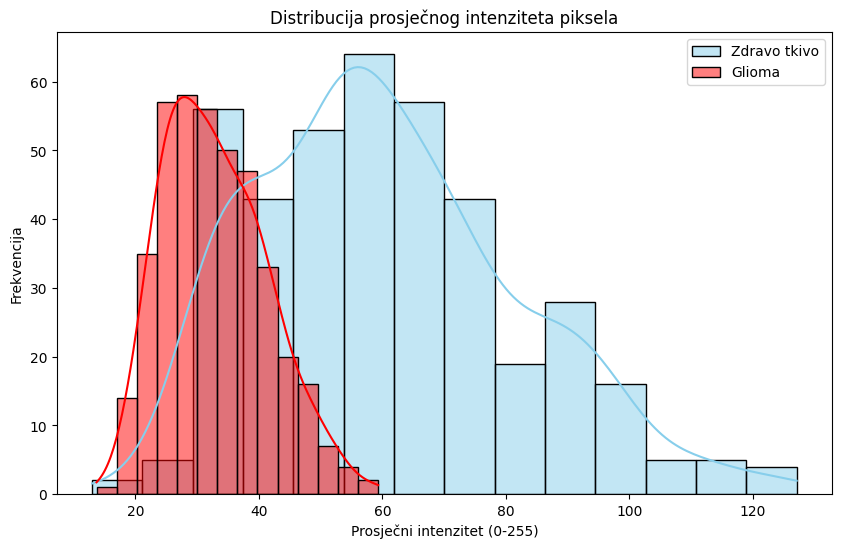

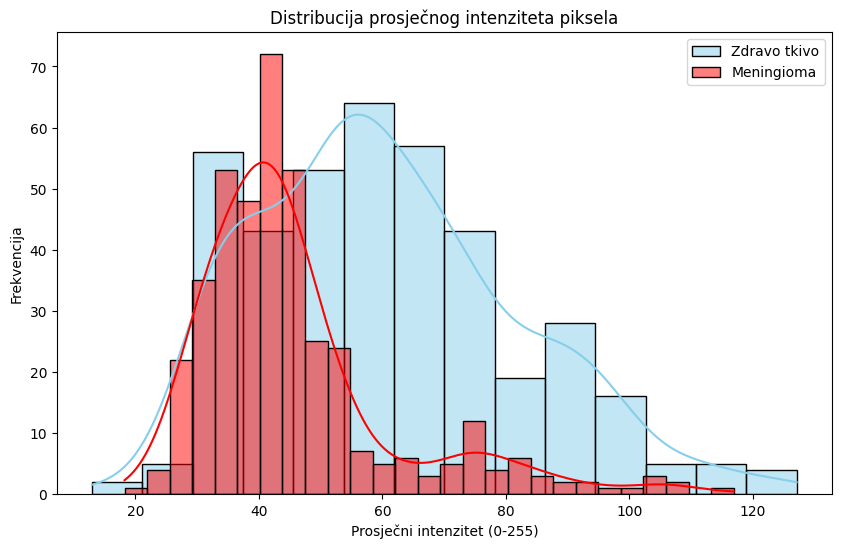

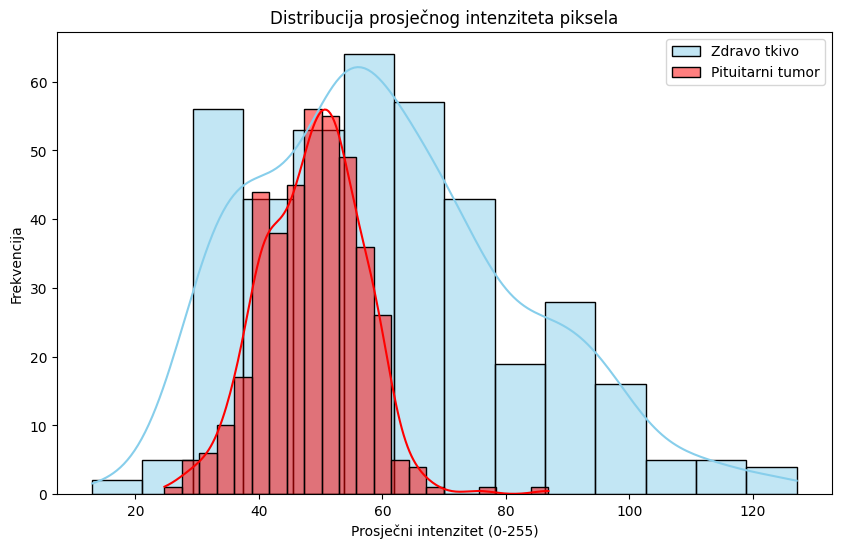

Shapiro-Wilk p-vrijednost (Zdravi): 0.0000
Shapiro-Wilk p-vrijednost (Glioma): 0.0000
Shapiro-Wilk p-vrijednost (Meningioma): 0.0000
Shapiro-Wilk p-vrijednost (Pituitarni): 0.0015
Mann-Whitney U test p-vrijednost (Glioma vs Zdravo): 0.0000
Mann-Whitney U test p-vrijednost (Meningioma vs Zdravo): 0.0000
Mann-Whitney U test p-vrijednost (Pituitarni vs Zdravo): 0.0000


In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(healthy_mean_pixel_intensity, color="skyblue", label="Zdravo tkivo", kde=True)
sns.histplot(glioma_mean_pixel_intensity, color="red", label="Glioma", kde=True)
plt.title('Distribucija prosječnog intenziteta piksela')
plt.xlabel('Prosječni intenzitet (0-255)')
plt.ylabel('Frekvencija')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(healthy_mean_pixel_intensity, color="skyblue", label="Zdravo tkivo", kde=True)
sns.histplot(meningioma_mean_pixel_intensity, color="red", label="Meningioma", kde=True)
plt.title('Distribucija prosječnog intenziteta piksela')
plt.xlabel('Prosječni intenzitet (0-255)')
plt.ylabel('Frekvencija')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(healthy_mean_pixel_intensity, color="skyblue", label="Zdravo tkivo", kde=True)
sns.histplot(pituitary_mean_pixel_intensity, color="red", label="Pituitarni tumor", kde=True)
plt.title('Distribucija prosječnog intenziteta piksela')
plt.xlabel('Prosječni intenzitet (0-255)')
plt.ylabel('Frekvencija')
plt.legend()
plt.show()

# Prvo provjeravamo normalnost (Shapiro-Wilk)
_, p_shapiro_h = stats.shapiro(healthy_mean_pixel_intensity)
_, p_shapiro_g = stats.shapiro(glioma_mean_pixel_intensity)
_, p_shapiro_m = stats.shapiro(meningioma_mean_pixel_intensity)
_, p_shapiro_p = stats.shapiro(pituitary_mean_pixel_intensity)

print(f"Shapiro-Wilk p-vrijednost (Zdravi): {p_shapiro_h:.4f}")
print(f"Shapiro-Wilk p-vrijednost (Glioma): {p_shapiro_g:.4f}")
print(f"Shapiro-Wilk p-vrijednost (Meningioma): {p_shapiro_m:.4f}")
print(f"Shapiro-Wilk p-vrijednost (Pituitarni): {p_shapiro_p:.4f}")

# Ako je p < 0.05, koristimo neparametarski Mann-Whitney U test

stat_g, p_val_g = stats.mannwhitneyu(healthy_mean_pixel_intensity, glioma_mean_pixel_intensity)
stat_m, p_val_m = stats.mannwhitneyu(healthy_mean_pixel_intensity, meningioma_mean_pixel_intensity)
stat_p, p_val_p = stats.mannwhitneyu(healthy_mean_pixel_intensity, pituitary_mean_pixel_intensity)

print(f"Mann-Whitney U test p-vrijednost (Glioma vs Zdravo): {p_val_g:.4f}")
print(f"Mann-Whitney U test p-vrijednost (Meningioma vs Zdravo): {p_val_m:.4f}")
print(f"Mann-Whitney U test p-vrijednost (Pituitarni vs Zdravo): {p_val_p:.4f}")


Mann-Whitney U test p-vrijednost: 0.0000
Mann-Whitney U test p-vrijednost: 0.0000
Mann-Whitney U test p-vrijednost: 0.0000


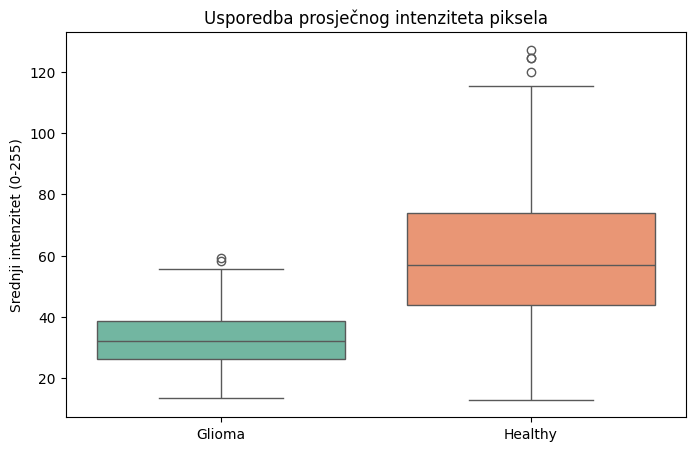

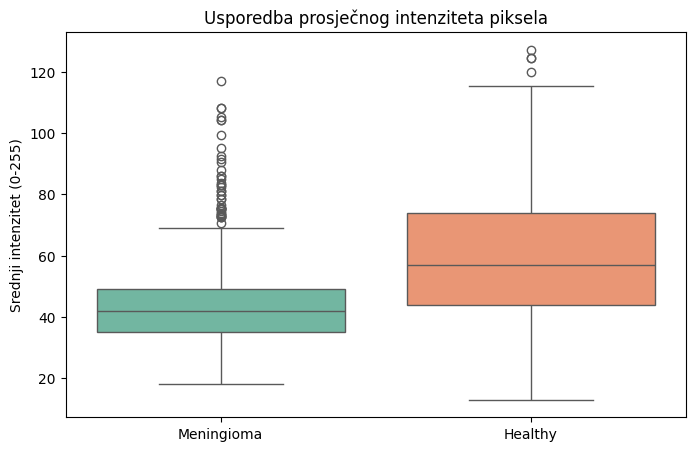

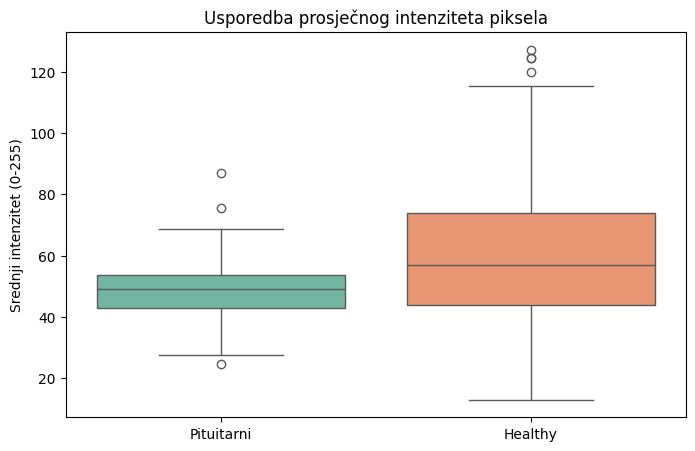

In [12]:
u_stat_g, p_val_g = stats.mannwhitneyu(glioma_mean_pixel_intensity, healthy_mean_pixel_intensity)
u_stat_m, p_val_m = stats.mannwhitneyu(meningioma_mean_pixel_intensity, healthy_mean_pixel_intensity)
u_stat_p, p_val_p = stats.mannwhitneyu(pituitary_mean_pixel_intensity, healthy_mean_pixel_intensity)

print(f"Mann-Whitney U test p-vrijednost: {p_val_g:.4f}")
print(f"Mann-Whitney U test p-vrijednost: {p_val_m:.4f}")
print(f"Mann-Whitney U test p-vrijednost: {p_val_p:.4f}")

plt.figure(figsize=(8, 5))
sns.boxplot(data=[glioma_mean_pixel_intensity, healthy_mean_pixel_intensity], palette="Set2")
plt.xticks([0, 1], ['Glioma', 'Healthy'])
plt.title('Usporedba prosječnog intenziteta piksela')
plt.ylabel('Srednji intenzitet (0-255)')
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=[meningioma_mean_pixel_intensity, healthy_mean_pixel_intensity], palette="Set2")
plt.xticks([0, 1], ['Meningioma', 'Healthy'])
plt.title('Usporedba prosječnog intenziteta piksela')
plt.ylabel('Srednji intenzitet (0-255)')
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=[pituitary_mean_pixel_intensity, healthy_mean_pixel_intensity], palette="Set2")
plt.xticks([0, 1], ['Pituitarni', 'Healthy'])
plt.title('Usporedba prosječnog intenziteta piksela')
plt.ylabel('Srednji intenzitet (0-255)')
plt.show()

### Statistička analiza i testiranje hipoteze

U ovom koraku ispitujemo postoji li značajna razlika u **prosječnom intenzitetu piksela** između slika zdravog mozga (`healthy`) i slika s tumorom. Ova značajka predstavlja prosječnu "svjetlinu" slike i služi kao jednostavan numerički indikator razlika u tkivu.

#### Provedeni testovi:
1. **Shapiro-Wilk test:** Korišten za provjeru normalnosti distribucije podataka.
   - **Rezultat:** Dobivena p-vrijednost je bila izrazito mala ($p \approx 0$), što znači da podaci značajno odstupaju od normalne distribucije.
   - **Zaključak:** Budući da je preduvjet normalnosti narušen, umjesto t-testa koristimo neparametarski **Mann-Whitney U test**.

2. **Mann-Whitney U test:** Korišten za usporedbu medijana dviju nezavisnih skupina (Glioma vs. Healthy).
   - **Hipoteza $H_0$:** Ne postoji sustavna razlika u intenzitetu piksela između ove dvije skupine.
   - **Hipoteza $H_1$:** Postoji statistički značajna razlika u intenzitetu piksela.

#### Interpretacija rezultata:
Dobivena p-vrijednost Mann-Whitney U testa iznosi **$p < 0.001$**. 

S obzirom na to da je p-vrijednost daleko manja od granice značajnosti ($\alpha = 0.05$), **odbacujemo nul-hipotezu**. Statistički test potvrđuje da se slike tumora i zdrave slike značajno razlikuju u pogledu intenziteta piksela. 



#### Poveznica s modelom strojnog učenja:
Ovaj rezultat nam pruža znanstvenu podlogu za primjenu konvolucijskih neuronskih mreža (CNN). Ako jednostavan statistički test može detektirati razliku u prosječnom intenzitetu, kompleksni model poput **VGG16** će moći prepoznati puno složenije prostorne obrasce i teksture tumora, što objašnjava visoku točnost klasifikacije koju postižemo.

### Generator podataka

In [18]:

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size=(224, 224), num_classes=5, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_paths = [self.image_paths[k] for k in indices]
        batch_labels = [self.labels[k] for k in indices]

        X = np.empty((self.batch_size, *self.target_size, 3), dtype=np.float32)

        for i, path in enumerate(batch_paths):

            img_cv2 = cv2.imread(path)

            if img_cv2 is None:
                print(f"Upozorenje: OpenCV nije uspio učitati sliku na lokalnom disku: {path}")
                continue

            # Konverzija iz BGR (OpenCV standard) u RGB (Keras/TensorFlow standard)
            img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

            img_resized = cv2.resize(img_rgb, self.target_size)

            img_array = img_resized.astype('float32') / 255.0

            X[i,] = img_array

        # One-hot encoding
        y = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)

        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

### Instanciranje generatora za svaki skup

In [19]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

train_generator = CustomDataGenerator(X_train_paths, y_train, BATCH_SIZE, TARGET_SIZE, shuffle=True)
validation_generator = CustomDataGenerator(X_val_paths, y_val, BATCH_SIZE, TARGET_SIZE, shuffle=False)
test_generator = CustomDataGenerator(X_test_paths, y_test, BATCH_SIZE, TARGET_SIZE, shuffle=False)

### Definiranje modela

U nastavku bilježnice definiramo duboki model (VGG16) koji će koristiti ove slike za kako bi ih naučio klasificirati u četiri navedene kategorije.

In [20]:
NUM_CLASSES = 5

base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False, # Ne uključujemo originalne klasifikacijske slojeve
    input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 12,848,133 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Treniranje modela

Model se trenira na 20 epoha.

In [21]:
NUM_EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator
)

c:\Users\nikol\Desktop\brain-tumor-classification\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.5920 - loss: 0.9884 - val_accuracy: 0.7857 - val_loss: 0.5672
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.8062 - loss: 0.4922 - val_accuracy: 0.8393 - val_loss: 0.4476
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.8902 - loss: 0.3415 - val_accuracy: 0.8527 - val_loss: 0.3905
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.8795 - loss: 0.3173 - val_accuracy: 0.8348 - val_loss: 0.4320
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.9241 - loss: 0.2208 - val_accuracy: 0.8527 - val_loss: 0.3519
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.9277 - loss: 0.1991 - val_accuracy: 0.8527 - val_loss: 0.3835
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.9411 - loss: 0.1861 - val_accuracy: 0.8661 - val_loss: 0.3705
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.9420 - loss: 0.1664 - val_accuracy: 0.8929 - v

Točnost na skupu za treniranje je malo manja od 100%, dok je točnost na skupu za validaciju oko 88%. Iz validacije se može zaključiti da su evaluacijeske metrike modela iz epohe u epohu sve bolje, što znači da model dobro uči.

### Evaluacija modela

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9062 - loss: 0.3024
Testna točnost: 90.62%
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step

--- Classification Report ---
              precision    recall  f1-score   support

      glioma       0.98      0.82      0.89        55
     healthy       0.96      0.96      0.96        54
  meningioma       0.80      0.88      0.84        60
   pituitary       0.91      0.96      0.94        55

    accuracy                           0.91       224
   macro avg       0.91      0.91      0.91       224
weighted avg       0.91      0.91      0.91       224



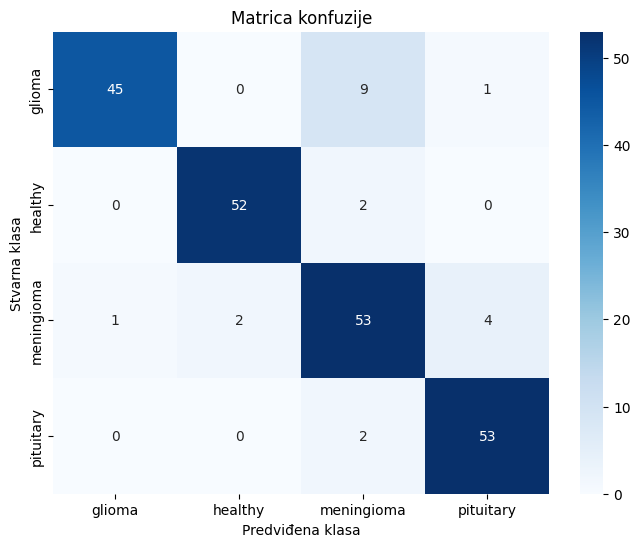

In [22]:
loss, accuracy = model.evaluate(test_generator)
print(f"Testna točnost: {accuracy*100:.2f}%")

y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_true_one_hot = []
for i in range(len(test_generator)):
    _, batch_y = test_generator[i]
    y_true_one_hot.extend(batch_y)
y_true = np.argmax(y_true_one_hot, axis=1)


target_names = ['glioma', 'healthy', 'meningioma', 'pituitary']
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_classes, target_names=target_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrica konfuzije')
plt.ylabel('Stvarna klasa')
plt.xlabel('Predviđena klasa')
plt.show()

### Zaključak i interpretacija rezultata modelaNa temelju dobivenog izvještaja o klasifikaciji
Možemo izvući sljedeće ključne zaključke:
- Visoka ukupna točnost (91%): 
    - Model pokazuje robusnost u razlikovanju zdravog tkiva od tri različita tipa tumora. S obzirom na kompleksnost MRI snimaka, ovo je vrlo visok rezultat koji potvrđuje snagu VGG16 arhitekture i transfernog učenja.
- Klasa "Healthy" (F1-score 0.96): 
    - Model gotovo nepogrešivo prepoznaje zdrave mozgove.
- Izazovi s Meningiomom (Precision 0.80): 
    - Primjećujemo nešto nižu preciznost kod meningioma. To znači da model ponekad druge tumore zamijeni za meningiom.
- Izvrsna osjetljivost (Recall) za Pituitary (0.96): 
    - Model gotovo nikada ne propušta tumore hipofize, što je ključno za ranu intervenciju.
- Iz matrice konfuzije se vidi da je jedino klasa meningioma klasificirana kao zdrava 2 puta. Iako je to jako mala brojka, ipak se radi o zdravlju i ljudskim životima. Bolje je da predvidimo da netko ima tumor, pa da sliku pogleda stručnjak i vidi da nema tumora, nego da predvidimo da netko nema tumor, a zapravo ga ima.

Konačni osvrt na projekt:
- Projekt je uspješno povezao cijeli proces podatkovne znanosti. Počevši od statističkog testiranja, gdje je dokazano da postoje značajne numeričke razlike u intenzitetu tkiva ($p < 0.001$), i naposljetku, s dubokim učenjem primijenjeno prethodno saznanje koje je te razlike iskoristilo za preciznu automatsku dijagnostiku. Ovakav sustav bi u praksi mogao služiti kao izvrstan alat za pomoć radiolozima u trijaži pacijenata.

Buduća poboljšanja i etička razmatranja:
- Iako model postiže visoku točnost, u medicinskom kontekstu ključno je minimizirati lažno negativne rezultate (slučajeve gdje pacijent ima tumor, a model ga proglasi zdravim). Analiza matrice konfuzije pokazala je da su se takvi slučajevi dogodili kod meningioma. Za budući razvoj sustava predlažu se sljedeća poboljšanja:

    - Prilagodba težina klasa (Class Weights): Uvođenje strožih kazni za model prilikom pogrešne klasifikacije tumora kao zdrave osobe. Time se model "prisiljava" na konzervativniji pristup dijagnozi.

    - Optimizacija praga odlučivanja (Threshold Tuning): Umjesto standardnog praga, model bi trebao zahtijevati ekstremno visoku vjerojatnost (npr. >95%) prije nego što sliku označi kao "zdravu", čime se povećava osjetljivost (recall) sustava.

    - Binarno-višeklasni hibridni pristup: Razvoj prvog "gatekeeper" modela koji samo dijeli slike na "zdrave" i "sumnjive", te drugog modela koji vrši detaljnu klasifikaciju tipa tumora.

    - Objašnjivost modela (XAI - Explainable AI): Korištenje tehnika poput Grad-CAM mapa topline kako bi radiolozi mogli vidjeti na koje se točno dijelove MRI snimke model oslanjao prilikom donošenja odluke, čime se povećava povjerenje u sustav.

### Spremanje modela

In [27]:

keras.saving.save_model(model, '../models/brain_tumor_classification_model.keras')